In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_datasets as tfds
import csv
from tqdm import tqdm
import PIL
from IPython.display import clear_output
#Authors: Richard Zhong, Chris Barry, Nitish Bodicharla

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create directory for folderID to file path
with open("/content/drive/MyDrive/FCN/image to description.csv") as x:
    data = list(csv.reader(x, delimiter=","))
# map of image file path to image type
image_to_description = {}
for row in data:
  #filter to only cropped images
  if row[1] == "cropped images":
    image_to_description[row[0]] = row[1]

# for image in image_to_description:
#   print(image_to_description[image])
folder_to_croppedimg = {}
for image in image_to_description:
  folder = image.split('/')[1]
  folder_to_croppedimg[folder] = image
# for folder in folder_to_croppedimg:
#   print(folder+"    "+folder_to_croppedimg[folder])

['1-083.jpg', '2-272.jpg']
['2-249.jpg', '1-250.jpg']


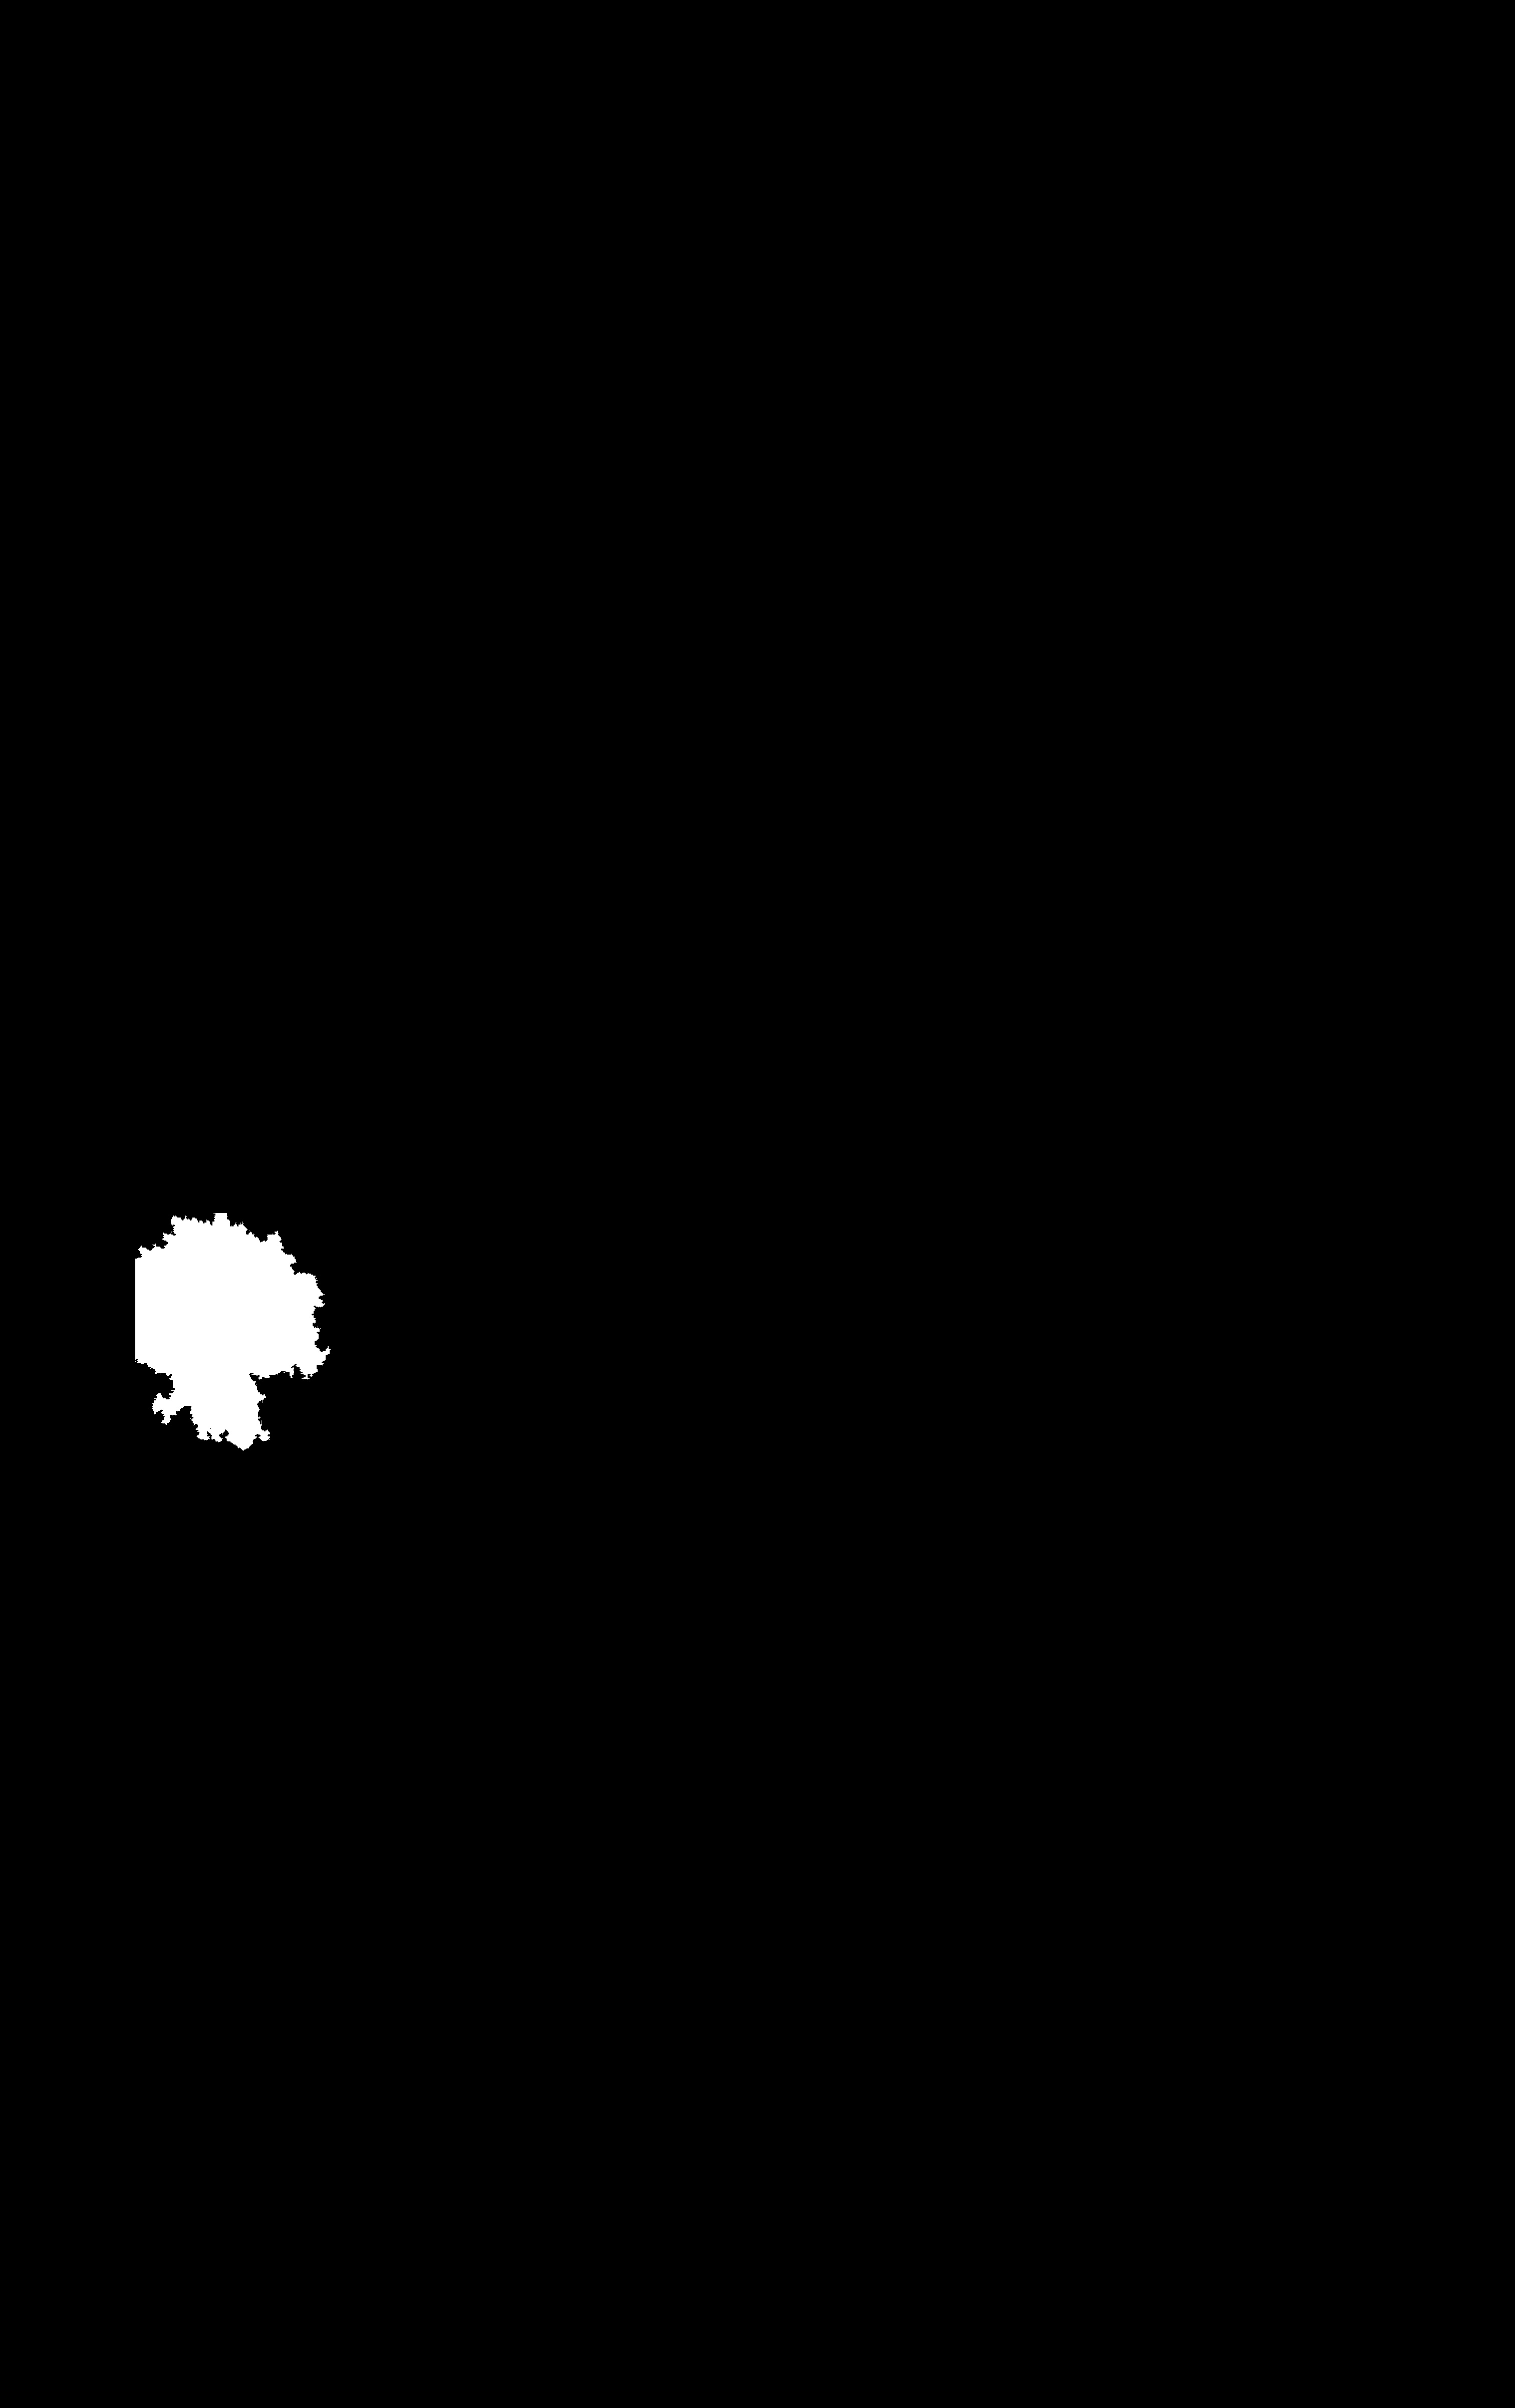

In [ ]:
# Load in training/test datasets
with open("drive/MyDrive/FCN/398MassTrain - Sheet1.csv", 'r') as x:
    train_data = list(csv.reader(x, delimiter=","))

for i, row in enumerate(train_data):
  if(i == 0):
    continue
  if row[0] == 'MALIGNANT':
    train_data[i][0] = 1
  else:
    train_data[i][0] = 0
  train_data[i][1] = train_data[i][1].split("/")[2]
  train_data[i][2] = train_data[i][2].split("/")[2]
  train_data[i][3] = train_data[i][3].split("/")[2]

with open("drive/MyDrive/FCN/389MassTest - Sheet1.csv", 'r') as y:
    test_data = list(csv.reader(y, delimiter=","))

for i, row in enumerate(test_data):
  if(i == 0):
    continue
  if row[0] == 'MALIGNANT':
    test_data[i][0] = 1
  else:
    test_data[i][0] = 0
  test_data[i][1] = test_data[i][1].split("/")[2]
  test_data[i][2] = test_data[i][2].split("/")[2]
  test_data[i][3] = test_data[i][3].split("/")[2]

# mass_train = np.array(sample_data)

# labels = mass_train[:,0][1:]


print(os.listdir("/content/drive/MyDrive/FCN/jpeg/" + test_data[1][2]))
dir1 = "/content/drive/MyDrive/FCN/jpeg/" + test_data[1][2] + "/" + os.listdir("/content/drive/MyDrive/FCN/jpeg/" + test_data[1][2])[1]
# print(image_to_description[dir[31:]])
PIL.Image.open(dir1)

print(os.listdir("/content/drive/MyDrive/FCN/jpeg/" + train_data[1][2]))
dir2 = "/content/drive/MyDrive/FCN/jpeg/" + train_data[1][2] + "/" + os.listdir("/content/drive/MyDrive/FCN/jpeg/" + train_data[1][2])[1]
PIL.Image.open(dir2)
# print(test_data[1][2])


In [ ]:
# process training/test datasets to label/filepath arrays
train_labels = []
train_images = []
test_labels = []
test_images = []
for i, row in enumerate(train_data):
  if i == 0:
    continue
  if(row[2] in folder_to_croppedimg):
    train_labels.append(row[0])
    train_images.append("/content/drive/MyDrive/FCN/" + folder_to_croppedimg[row[2]])
for i, row in enumerate(test_data):
  if i == 0:
    continue
  if(row[2] in folder_to_croppedimg):
    test_labels.append(row[0])
    test_images.append("/content/drive/MyDrive/FCN/" + folder_to_croppedimg[row[2]])
print(len(test_images))
print(len(test_labels))


378
378


In [ ]:
# create tensorflow dataset object from train/test arrays
train_filenames = tf.constant(train_images)
train_labels = tf.constant(train_labels)
test_filenames = tf.constant(test_images)
test_labels = tf.constant(test_labels)

# step 2: create a dataset returning slices of `filenames`
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))

# step 3: parse every image in the dataset using `map`
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)/255.0 #store rgb values as float, divide by 255 to get all vals between 0,1
    image = tf.image.resize_with_pad(image,299,299) #resize image
    return image, label

# element[0]
train_dataset = train_dataset.map(_parse_function)
test_dataset = test_dataset.map(_parse_function)
train_dataset = train_dataset.batch(128)#batch adjustment here
test_dataset = test_dataset.batch(128)

In [ ]:
# seeing distribution of image shapes, settled on 370x370 for resize 
# don't run this block unless you want to test sizes
shapes = []
print(len(test_dataset))
for e in test_dataset:
  shape = e[0].shape
  shapes.append([shape[0],shape[1],shape[2]])

shapes = np.array(shapes)
mins = np.amin(shapes, axis=0)
maxs = np.amax(shapes, axis=0)
avgs = np.average(shapes, axis=0)
print(mins)
print(maxs)
print(avgs)

hist, bins = np.histogram(shapes[:,0])
print(hist)
print(bins)

3


KeyboardInterrupt: ignored

In [ ]:
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

TEST MODEL

In [ ]:
# defining model and layers (most of this it taken from:
#  https://www.tensorflow.org/tutorials/quickstart/beginner 
# TODO: get this block to incorporate matplotlib (build off code from hw? might need to google for tensorflow differences)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(1,5, activation = 'relu', input_shape=(370, 370, 3)),
  tf.keras.layers.Conv2D(5,10, activation="relu", input_shape=(366, 366, 1)),
  tf.keras.layers.Flatten(input_shape=(357, 357, 5)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2)
])
loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
callbacks_list = [PlotLearning()]
history = model.fit(train_dataset, validation_data=test_dataset, epochs=1)
loss, accuracy = model.evaluate(test_dataset)

FCN MODEL

In [ ]:
def FCN_model(len_classes=2, dropout_rate=0.2):
    
    # Input layer
    input = tf.keras.layers.Input(shape=(None, None, 3))

    # convolution block 1
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)(input)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Conv block 2
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=2)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Conv block 3
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=6, strides=3)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Conv block 4
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=7, strides=5)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Conv block 5
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=8, strides=6)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Fully connected conv layer 1
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    #Last FC layer
    x = tf.keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('sigmoid')(x)

    model = tf.keras.Model(inputs=input, outputs=predictions)
    print(model.summary())
    return model

def train(model, traindata, testdata, epochs = 1, lr = 0.0001):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

    checkpoint_path = '/content/drive/MyDrive/FCN/checkpoints'
    os.makedirs(checkpoint_path, exist_ok=True)
    model_path = os.path.join(checkpoint_path, 'model_epoch_{epoch:02d}_loss_{loss:.2f}.h5')
    history = model.fit(traindata, validation_data=testdata, epochs=epochs, callbacks=[tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', save_best_only=True, verbose=1)])
    return history

BLOCK RUNS FCN MODEL

In [ ]:
# HYPERPARAMS
EPOCHS = 20
LR = 0.0001
BATCH = 64

# create tensorflow dataset object from train/test arrays
train_filenames = tf.constant(train_images)
train_labels = tf.constant(train_labels)
test_filenames = tf.constant(test_images)
test_labels = tf.constant(test_labels)

# step 2: create a dataset returning slices of `filenames`
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))

# step 3: parse every image in the dataset using `map`
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)/255.0 #store rgb values as float, divide by 255 to get all vals between 0,1
    image = tf.image.resize_with_pad(image,370,370) #resize image
    return image, label

train_dataset= train_dataset.map(_parse_function)
test_dataset = test_dataset.map(_parse_function)
train_dataset = train_dataset.batch(BATCH)
test_dataset = test_dataset.batch(BATCH)

checkpoint_path = '/content/drive/MyDrive/FCN/checkpoints'
model_path = os.path.join(checkpoint_path, 'model_epoch_20_loss_0.24.h5')
model = FCN_model(len_classes=2, dropout_rate=0.2)
model.load_weights(model_path)
history = train(model, train_dataset, test_dataset, epochs=EPOCHS, lr=LR)
loss, accuracy = model.evaluate(test_dataset)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 dropout (Dropout)           (None, None, None, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, None, None, 32)   128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    51264     
                                                             

In [ ]:
#GET PREDICTION BATCHES
predictions_batches = []
actual_batches = []

for x, y in test_dataset:
  pred = model.predict(x)
  predictions_batches.append(pred)
  actual_batches.append(y)

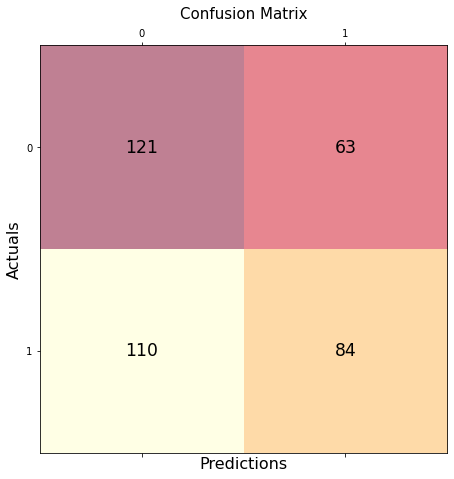

In [ ]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix

actual = []
predictions = []
for i in range(len(predictions_batches)):
  for j in range(len(predictions_batches[i])):
    predictions.append(0) if predictions_batches[i][j][0] > predictions_batches[i][j][1] else predictions.append(1)
    actual.append(actual_batches[i][j])

predictions = tf.constant(predictions)
mat_con = (confusion_matrix(actual, predictions))

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(mat_con, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(mat_con.shape[0]):
    for n in range(mat_con.shape[1]):
        px.text(x=m,y=n,s=mat_con[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
{'loss': [0.2443436235189438, 0.2525639533996582, 0.2435465008020401, 0.23842540383338928, 0.23798610270023346, 0.22823600471019745, 0.22568155825138092, 0.217829629778862, 0.21914149820804596, 0.21616612374782562, 0.21847128868103027, 0.20869630575180054, 0.2121807485818863, 0.2117835134267807, 0.20628675818443298, 0.2049134522676468, 0.20515604317188263, 0.19529975950717926, 0.20715883374214172, 0.19570906460285187], 'accuracy': [0.9582701325416565, 0.9514415860176086, 0.9681335091590881, 0.9658573865890503, 0.9696509838104248, 0.9704096913337708, 0.9734446406364441, 0.9719271659851074, 0.9764795303344727, 0.9817906022071838, 0.97420334815979, 0.9802731275558472, 0.9810318946838379, 0.9779969453811646, 0.9825493097305298, 0.974962055683136, 0.9810318946838379, 0.9863429665565491, 0.9787557125091553, 0.987860381603241], 'val_loss': [0.9427605867385864, 1.194999098777771, 0.9940820336341858, 0.9431004524230957, 0.8499363660812

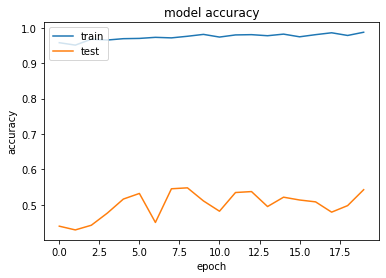

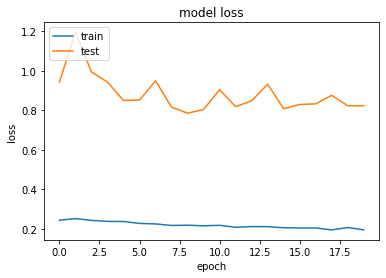

In [ ]:
# list all data in history
print(history.history.keys())
print(history.history)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()